# Иследование для сервиса Go fast для оптимизации и увелечения выручки

**Описание проекта**
Вам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:

без подписки
абонентская плата отсутствует;

стоимость одной минуты поездки — 8 рублей;

стоимость старта (начала поездки) — 50 рублей;

с подпиской Ultra

абонентская плата — 199 рублей в месяц;

стоимость одной минуты поездки — 6 рублей;

стоимость старта — бесплатно.

**Цель проекта**

1-Изучить данные о пользователях

2-Произвести рассчеты,построить графики

3-На основе достижения цели **№** 2 предоставить рекомендации,для роста бизнеса

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import numpy as np
from scipy.stats import binom
from math import sqrt
import numpy as np

#### Шаг 1. Загрузка данных

**Таблица пользователей**

In [2]:
df_user=pd.read_csv('/datasets/users_go.csv')
df_user.info()
df_user.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


,user_id,name,age,city,subscription_type
1538,908,Рустам,30,Тюмень,free
1091,1092,Ярослава,25,Ростов-на-Дону,free
1098,1099,Назар,23,Тюмень,free
566,567,Камилла,33,Ростов-на-Дону,ultra
1235,1236,Александр,31,Екатеринбург,free


**Описание данных**

**user_id**-id  пользователя

**name**- Имя пользователя

**age**-Возраст пользователя

**city**- Город

**subscription_type**- Тип подписки

Тип данных столбцов -впордяке

**Таблица поездок**

In [3]:
df_rides=pd.read_csv('/datasets/rides_go.csv')
df_rides.info()
df_rides.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


,user_id,distance,duration,date
12761,1158,3191.772375,24.079281,2021-08-14
5342,573,4864.283166,22.241062,2021-03-10
10517,993,4262.941508,25.314708,2021-08-28
1996,216,3218.199974,20.776909,2021-03-18
9936,953,2795.095350,20.826617,2021-03-05


**Описание данных**

**user_id**-id  пользователя

**distance**- Расстояние поездки

**duration**-Продолжительность поездки

**date**- Дата поездки



Тип файлов в столбце **date** нужно привести к типу **datetime** и **distance** к **int**

In [4]:
df_sub=pd.read_csv('/datasets/subscriptions_go.csv')
df_sub.info()
df_sub.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


**Описание данных**

**subscription_type**-Наличие подписки

**minute_price**-Стоимость минуты поездки(8 рублей -без подписки,6 рублей с подпиской)

**start_ride_price** -Стоимость начала поездки(50 рублей - безд подспики,бесплатно - с подпиской)

**subscription_fee**-Абонентская плата в месяц(отсутвует- без подписки,199 рублей - с подпиской)


Класс типов данных впорядке

**Вывод:**
При изучении 3 датафреймов,был выявлен неверный формат данных в стобце **date**.А так же просмотрена общая информация о них и составлено описание столбцов.
Займемся предобраткой данных

#### Шаг 2. Предобработка данных

Изучим столбцы подробнее.Посмотрим количество пропсков в каждом их них,а так же наличие явных и не явных дубликатов,преобразуем тип данных= там где он требуется

**2.1 Преобразование типов данных**

In [5]:
df_rides['date']=pd.to_datetime(df_rides['date'],format='%Y-%m-%d')
#проверим
df_rides['date'].sample(5)

10420   2021-10-22
2001    2021-03-02
15207   2021-11-28
10261   2021-07-12
17114   2021-03-16
Name: date, dtype: datetime64[ns]

**2.2 Создание столбца с номером месяца**

In [6]:
df_rides['month']=df_rides['date'].dt.month
#проверим
df_rides.sample(10)

,user_id,distance,duration,date,month
2764,295,3379.139775,14.109935,2021-02-20,2
3462,372,3313.363176,19.952072,2021-10-20,10
13277,1196,2923.207871,15.491729,2021-03-08,3
11251,1047,1378.395128,13.518519,2021-11-10,11
14271,1262,4348.810805,21.348744,2021-12-24,12
6959,731,2196.807653,9.545119,2021-04-21,4
4104,442,4470.269288,26.158297,2021-11-14,11
9023,888,2365.427589,20.461710,2021-08-08,8
415,45,2923.294657,18.945244,2021-01-24,1
13536,1213,644.612093,6.275102,2021-03-26,3


**2.3 Пропуски**

In [7]:
#Посмотрим количество пропусков в таблице пользвателей,подписок,поездок
print('Пропусков в таблице пользователей:',df_user.value_counts().isna().sum())
print('Пропусков в таблице поездок:',df_rides.value_counts().isna().sum())
print('Пропусков в таблице подписок:',df_sub.value_counts().isna().sum())

Пропусков в таблице пользователей: 0
Пропусков в таблице поездок: 0
Пропусков в таблице подписок: 0


**2.4 Явные дубликаты**

In [8]:
print('Явных дубликатов в таблице пользователей:',df_user.duplicated().sum())
print('Явных дубликатов в таблице поездок:',df_rides.duplicated().sum())
print('Явных дубликатов в таблице подписок:',df_sub.duplicated().sum())

Явных дубликатов в таблице пользователей: 31
Явных дубликатов в таблице поездок: 0
Явных дубликатов в таблице подписок: 0


In [9]:
#Избавимся от дубликатов
df_user=df_user.drop_duplicates().reset_index(drop=True)
#проверим
print('Явных дубликатов в таблице пользователей:',df_user.duplicated().sum())

Явных дубликатов в таблице пользователей: 0


**Неявные дубликаты**

In [10]:
df_user['name'].sort_values().unique()

array(['Агата', 'Аделина', 'Адель', 'Айдар', 'Александр', 'Александра',
       'Алексей', 'Алина', 'Алиса', 'Алия', 'Алла', 'Альберт', 'Альбина',
       'Алёна', 'Амалия', 'Амина', 'Амир', 'Анастасия', 'Анатолий',
       'Ангелина', 'Андрей', 'Анжелика', 'Анна', 'Антон', 'Антонина',
       'Ариана', 'Арина', 'Арсен', 'Арсений', 'Артемий', 'Артур', 'Артём',
       'Богдан', 'Борис', 'Вадим', 'Валентина', 'Валерий', 'Валерия',
       'Варвара', 'Василий', 'Василина', 'Василиса', 'Вера', 'Вероника',
       'Виктор', 'Виктория', 'Виолетта', 'Виталий', 'Виталина', 'Влад',
       'Влада', 'Владимир', 'Владислав', 'Владислава', 'Всеволод',
       'Вячеслав', 'Галина', 'Георгий', 'Герман', 'Глеб', 'Гордей',
       'Григорий', 'Давид', 'Дамир', 'Даниил', 'Данил', 'Данила',
       'Даниэль', 'Дарина', 'Дарья', 'Демид', 'Денис', 'Диана', 'Дмитрий',
       'Ева', 'Евгений', 'Евгения', 'Егор', 'Екатерина', 'Елена',
       'Елизавета', 'Елисей', 'Есения', 'Жанна', 'Зарина', 'Захар',
       'Злата', 

In [11]:
df_user['city'].sort_values().unique()

array(['Екатеринбург', 'Краснодар', 'Москва', 'Омск', 'Пятигорск',
       'Ростов-на-Дону', 'Сочи', 'Тюмень'], dtype=object)

Неявных дубликатов не выявлено

**Вывод:**

 На этапе предобработки данных были изменены 2 столбца **date** ---> **datetime** И **distance** ---> **int**
 
 Даже к датафрейму был добавлен столбец с Месяцами по номерам
 
 Пропусков не выявлено
 
 Явные дубликаты были выявлены в датафрейме **User** и успешно удалены
 
 Не янвных дубликатов не выявлено

#### Шаг . Исследовательский анализ данных

3.1 Частота встречаемости городов

In [12]:
df_user['city'].value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

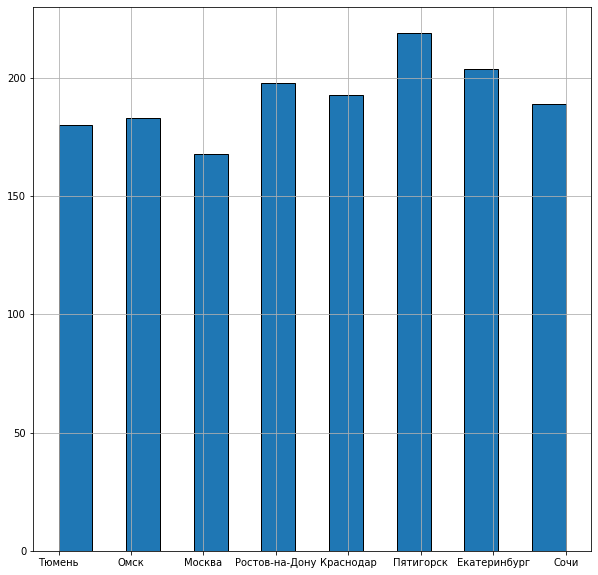

In [13]:
df_user['city'].hist(bins=15,figsize=(10,10),edgecolor="black")
plt.show()

Произвели расчет частоты встречаемости городов и визуализировали это

Из расчетов видно,что **Пятигорск** и  **Екатеринбург** самые популярные города их значение превышает 200 ед.

Город который реже всего встречается это **Москва** его значение составляет 168 ед.

**3.2 Cоотношение пользователей с подпиской и без подписк**

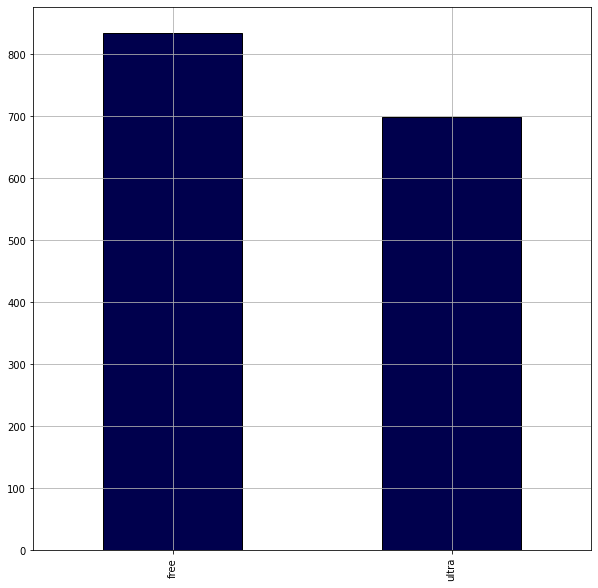

In [14]:
df_user['subscription_type'].value_counts().plot(kind='bar',stacked=True,grid=True,colormap='seismic',figsize=(10,10),edgecolor="black");


На графике видно,что соотношение пользователей без подписки преобладают примерно на 10%,над пользователями с "ней"

**3.3 Возраст пользователей**

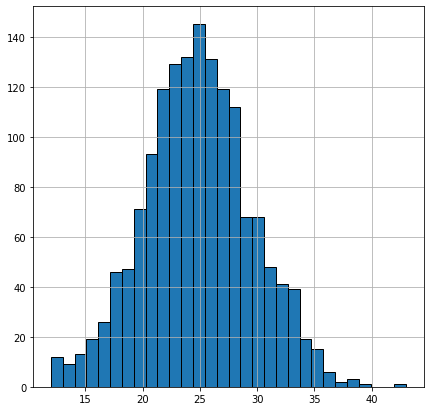

In [15]:
df_user['age'].hist(bins=30,figsize=(7,7),ec='black');


График отображает что самые популярные пользователи это люди в возрасте от 23-26 лет

Меньше всего пользователей это люди из восрастной категории 'подростки'14-17 лет и взрослые 36 40 лет

**3.4 Pасстояние, которое пользователь преодолел за одну поездку**

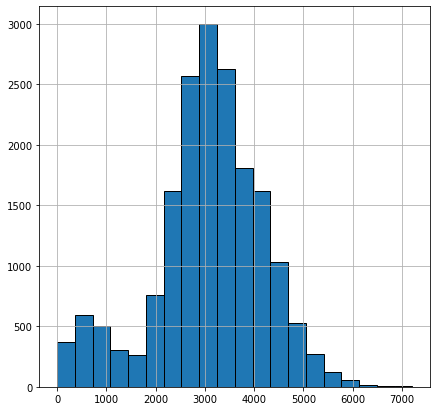

In [16]:
df_rides['distance'].hist(bins=20,figsize=(7,7),ec='black');

График показывает,что чаще всего пользователи совершают поездки от 2.5 до 4.5 км

Очень редко,пользователи ездиют на дистанции свыше 5км

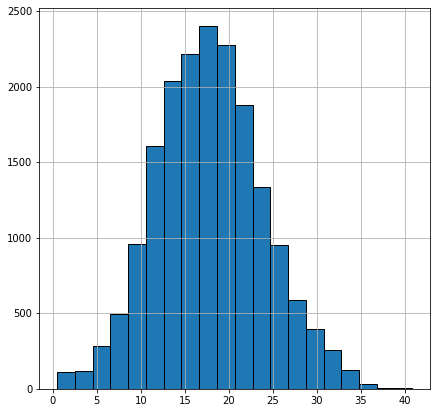

In [17]:
df_rides['duration'].hist(bins=20,figsize=(7,7),ec='black');

На графике видно,что в среднем пользователи тратят на поездку от 12 до 22 минут

**На этапе иследовательского анализа данных было построенно 5 графиков и даны к ним пояснения**

На первом графике были отображены города,самые популярные Пятигорк и ЕКБ

На втором графике было отображено количество пользователей с подпиской и без-Пользователи без подписки преобладают на 10%

на третьем графике отображен возраст пользователей

На четвертом расстояние поездки

На пятом среднея продолжительность всех поездок

#### Шаг 4. Объединение данных

In [18]:
#объеденим датафрейм
df=df_user.merge(df_rides).merge(df_sub)
#проверим
df.sample(10).T

,17732,12749,9458,12404,8313,9995,11292,3406,9990,1835
user_id,1511,1157,919,1132,834,957,1050,368,957,198
name,Элина,Рустам,Марат,Наталия,Давид,Эльвира,Богдан,Валентина,Эльвира,Марсель
age,27,24,24,20,29,20,32,32,20,27
city,Краснодар,Екатеринбург,Краснодар,Москва,Пятигорск,Тюмень,Пятигорск,Екатеринбург,Тюмень,Сочи
subscription_type,free,free,free,free,free,free,free,ultra,free,ultra
distance,4891.577222,3325.00633,364.853748,3713.11306,4003.115171,2262.699705,2129.731326,2981.594397,5087.123324,2736.584934
duration,14.481951,13.735316,9.368202,22.568722,18.578104,20.145367,10.099104,17.131621,30.747945,29.41951
date,2021-08-18 00:00:00,2021-07-13 00:00:00,2021-07-29 00:00:00,2021-03-23 00:00:00,2021-06-28 00:00:00,2021-08-01 00:00:00,2021-04-26 00:00:00,2021-02-20 00:00:00,2021-06-06 00:00:00,2021-08-02 00:00:00
month,8,7,7,3,6,8,4,2,6,8
minute_price,8,8,8,8,8,8,8,6,8,6


In [19]:
df.describe()

,user_id,age,distance,duration,month,minute_price,start_ride_price,subscription_fee
count,18068.000000,18068.000000,18068.000000,18068.000000,18068.000000,18068.000000,18068.000000,18068.000000
mean,842.869936,24.893071,3070.659976,17.805011,6.486772,7.280496,32.012398,71.590658
std,434.734317,4.582216,1116.831209,6.091051,3.437410,0.959882,23.997045,95.508238
min,1.000000,12.000000,0.855683,0.500000,1.000000,6.000000,0.000000,0.000000
25%,487.000000,22.000000,2543.226360,13.597563,4.000000,6.000000,0.000000,0.000000
50%,889.000000,25.000000,3133.609994,17.678395,6.000000,8.000000,50.000000,0.000000
75%,1213.250000,28.000000,3776.222735,21.724800,9.000000,8.000000,50.000000,199.000000
max,1534.000000,43.000000,7211.007745,40.823963,12.000000,8.000000,50.000000,199.000000


**4.1 Создание 2ух датафреймов(с подпиской и без)**

In [20]:
#создание датафрейма с подпиской
df_w_sub=df[df['subscription_type']=='ultra']
#Проверка
df_w_sub.sample(10)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
3017,323,Дарья,28,Краснодар,ultra,3376.153292,32.256920,2021-10-28,10,6,0,199
3001,322,Руслан,17,Екатеринбург,ultra,4180.527046,18.944363,2021-01-13,1,6,0,199
4435,478,Стефания,28,Ростов-на-Дону,ultra,3370.292594,18.638597,2021-03-20,3,6,0,199
2773,295,Влада,16,Ростов-на-Дону,ultra,3590.248702,17.693390,2021-11-16,11,6,0,199
5089,547,Юрий,26,Тюмень,ultra,3104.713378,21.523567,2021-11-12,11,6,0,199
6196,665,Герман,12,Сочи,ultra,4045.141255,12.989203,2021-08-01,8,6,0,199
4700,505,Виктор,27,Сочи,ultra,501.199481,8.313228,2021-12-22,12,6,0,199
1635,176,Анна,17,Москва,ultra,4615.947874,18.386493,2021-01-29,1,6,0,199
164,16,Амалия,27,Краснодар,ultra,3476.061778,16.448704,2021-09-21,9,6,0,199
2985,320,Оксана,30,Екатеринбург,ultra,2259.390484,17.296952,2021-07-21,7,6,0,199


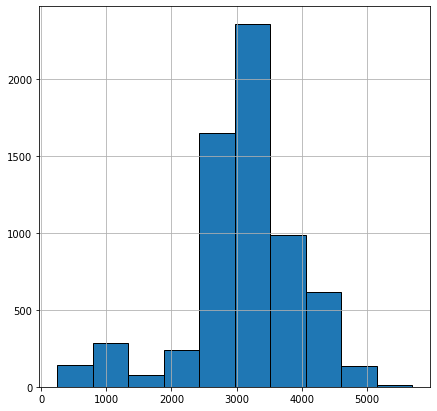

In [21]:
df_w_sub['distance'].hist(figsize=(7,7),ec='black');

По графику можно судить,что пользователи с подпиской проезжают меньше киллометров, самые популряные заказы от от 6 до 12 км

Так видно что пользователи с подпиской проезжают в целом меньше км,так как максимальная дальность поездки 21км


In [22]:
df_w_sub['duration'].describe()

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

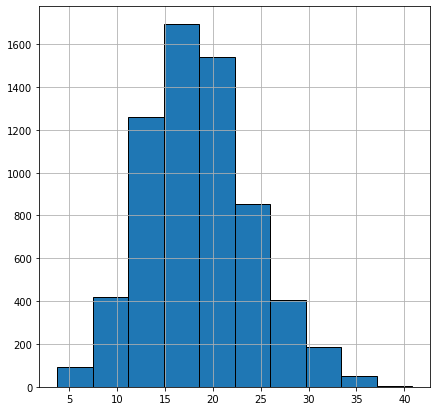

In [23]:
df_w_sub['duration'].hist(figsize=(7,7),ec='black');

По графикам видно,что обычно пользователи с подпиской тратят на поездку от 14 до 23 минут

Минимально 3 максимально 40

In [24]:
#Создание датафрейма без подписки
df_free=df[df['subscription_type']=='free']
df_free.sample(10)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
10152,968,Павел,35,Краснодар,free,3600.694930,21.641668,2021-04-15,4,8,50,0
15456,1352,Евгения,30,Москва,free,3892.708237,10.983173,2021-08-01,8,8,50,0
15162,1328,Нелли,30,Омск,free,2456.099583,11.912199,2021-03-06,3,8,50,0
17588,1502,Аделина,18,Омск,free,3445.156190,21.159375,2021-01-31,1,8,50,0
15178,1328,Нелли,30,Омск,free,4985.793793,28.957381,2021-11-27,11,8,50,0
10462,990,Елена,23,Сочи,free,3884.185109,31.420926,2021-02-14,2,8,50,0
7307,756,Руслан,28,Екатеринбург,free,2691.593365,18.093475,2021-11-28,11,8,50,0
17233,1476,Стефания,13,Москва,free,4011.565565,15.914590,2021-02-27,2,8,50,0
7550,775,Вероника,24,Екатеринбург,free,2712.392029,16.794866,2021-04-25,4,8,50,0
12102,1109,Демид,25,Ростов-на-Дону,free,302.267316,3.863621,2021-10-23,10,8,50,0


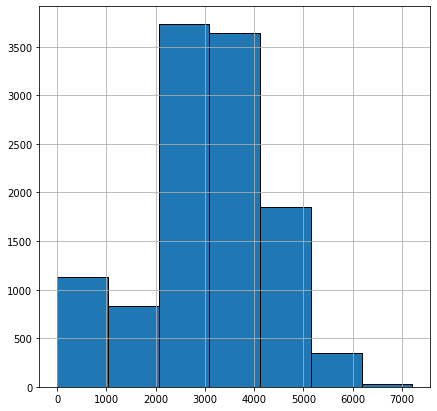

In [25]:
df_free['distance'].hist(bins=7,figsize=(7,7),ec='black');

По графику видно,что обычно пользователи без подписки ездиют от 2 до 4 километров

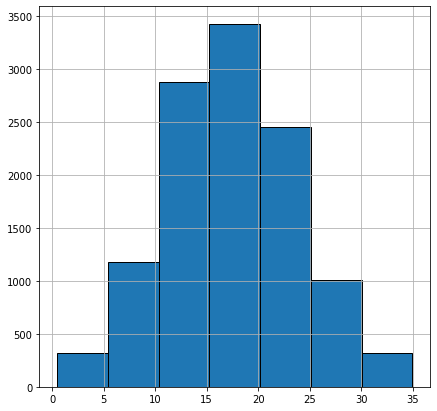

In [26]:
df_free['duration'].hist(bins=7,figsize=(7,7),ec='black');

На графикам видно,что пользователи без подписки тратят врея на поездко от 12 до 20 минут!

Минимально пол минуты- скорее всего пользователь взял по ошибке либо ему не понравилось и он отказался
Максимально 35

In [27]:
df_free.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,11568.0,1120.527230,241.165628,700.000000,915.000000,1123.000000,1328.000000,1534.000000
age,11568.0,24.893326,4.481100,12.000000,22.000000,25.000000,28.000000,43.000000
distance,11568.0,3045.495282,1246.173806,0.855683,2366.562689,3114.648465,3905.697894,7211.007745
duration,11568.0,17.390909,6.326803,0.500000,12.958437,17.326890,21.594071,34.948498
month,11568.0,6.522994,3.449770,1.000000,4.000000,7.000000,9.000000,12.000000
minute_price,11568.0,8.000000,0.000000,8.000000,8.000000,8.000000,8.000000,8.000000
start_ride_price,11568.0,50.000000,0.000000,50.000000,50.000000,50.000000,50.000000,50.000000
subscription_fee,11568.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Вывод:

Все 3 датарфейма были слиты в один

Из единого датафрейма были созданы еще 2 Один отображает ползователей с подпиской другой без нее

Так же с успехом были построены 2 графика для 2 ух таблиц(для пользователей с подпиской и без)-отображающие дтсьанцию поездки

По графикам и расчетам с продолжительснотью поездки можно сделать вывод,что пользователи с подпиской проводят время за самокатом дольше,чем пользователи без нее.

В среднем пользователь с подпиской проезжает 6-12 км за 14-23 минут

Пользователь без подписки проезжает 2-4 км за 12-20 минут

Из этого следует,что пользователи с подпиской пользуются самокатом скорее всего для поездок на работу или куда -то еще,в общем для определенных целей.

В то время как пользователи без подписки проезжаютт расстояние в 3 раза меньше.Это говорит о том,что скорее всего они берут самокаты в целях развлечения,могут просто покататься с друзьями,оставиться поесть мороженого и поболтать


#### Шаг 5. Подсчёт выручки

**5.1**
Cоздадим датафрейм с агрегированными данными и найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [28]:
agg=df.groupby(['user_id', 'month']).agg({'distance': 'sum',
                                              'user_id': 'count','duration': 'sum',
                                               'subscription_type': 'unique',
                                              'minute_price': 'sum',
                                              'start_ride_price': 'sum',
                                              'subscription_fee': 'sum'})
agg['count'] = agg['user_id']
agg=agg.drop(columns = ('user_id'))
agg=np.round(agg)
agg

distance  duration subscription_type  minute_price  \
user_id month                                                       
1       1        7028.0      41.0           [ultra]            12   
        4         754.0       6.0           [ultra]             6   
        8        6723.0      45.0           [ultra]            12   
        10       5810.0      32.0           [ultra]            12   
        11       7003.0      53.0           [ultra]            18   
...                 ...       ...               ...           ...   
1534    6        3409.0      25.0            [free]            16   
        8        7622.0      47.0            [free]            16   
        9        4928.0      23.0            [free]             8   
        11      13350.0      76.0            [free]            32   
        12       2372.0      16.0            [free]             8   

               start_ride_price  subscription_fee  count  
user_id month                                             
1       1                     0               398      2  
        4                     0               199      1  
        8                     0               398      2  
        10                    0               398      2  
        11                    0               597      3  
...                         ...               ...    ...  
1534    6                   100                 0      2  
        8                   100                 0      2  
        9                    50                 0      1  
        11                  200                 0      4  
        12                   50                 0      1  

[11331 rows x 7 columns]

**5.3**

Создадим датафрейм и добавим к нему столбец помесячной выручкой, которую принёс каждый пользователь 

In [29]:
agg['month_cash']=agg['start_ride_price']*agg['count']+agg['minute_price']*agg['duration']+agg['subscription_fee']
agg

distance  duration subscription_type  minute_price  \
user_id month                                                       
1       1        7028.0      41.0           [ultra]            12   
        4         754.0       6.0           [ultra]             6   
        8        6723.0      45.0           [ultra]            12   
        10       5810.0      32.0           [ultra]            12   
        11       7003.0      53.0           [ultra]            18   
...                 ...       ...               ...           ...   
1534    6        3409.0      25.0            [free]            16   
        8        7622.0      47.0            [free]            16   
        9        4928.0      23.0            [free]             8   
        11      13350.0      76.0            [free]            32   
        12       2372.0      16.0            [free]             8   

               start_ride_price  subscription_fee  count  month_cash  
user_id month                                                         
1       1                     0               398      2       890.0  
        4                     0               199      1       235.0  
        8                     0               398      2       938.0  
        10                    0               398      2       782.0  
        11                    0               597      3      1551.0  
...                         ...               ...    ...         ...  
1534    6                   100                 0      2       600.0  
        8                   100                 0      2       952.0  
        9                    50                 0      1       234.0  
        11                  200                 0      4      3232.0  
        12                   50                 0      1       178.0  

[11331 rows x 8 columns]

**Вывод**

Был создан датафрейм с агрегированными данными

В нем были найдены суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

А так же благодаря расчетам за в предыидущем пункте были произведены расчеты помесячной выручкой, которую принёс каждый пользователь и добавлены в дадатфрейм

#### Шаг 6. Проверка гипотез

**6.1  Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то действительно ли пользователи с подпиской «выгоднее» для компании.**

Для проверки возьмём двухсторонюю гипотезу, так как значения могут варьироваться в обе стороны от среднего в стандартном распределении и значения с обеих сторон будут иметь значение.

Для этого за основу возьмем Н0 время продолжительности поездки на тарфиах free и ultra равны

В таком случае альтернативная Н1 будет звучать так время продолжительности поездок на free и ultra неравны,различаются

Уровень значимости возьмём стандартный: 5%.

Параметр equal_var укажем как False, так как выборки различаются и это может негативно повлиять на результат исследования.

Проведём исследование:

In [30]:
alpha=0.05
results = st.ttest_1samp(df_w_sub['duration'],popmean=17.805011,alternative='greater')
print('p-value:',1-results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем гипотезу')
else:
    print('Не отвергаем гипотезу')

p-value: 1.0
Отвергаем гипотезу


**6.2 Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, меньше 3130 метров?**

Для проверки возьмем односторннию гипотезу

Н0 - Отвергаем,что расстояние которые проезжают пользователи с подпиской **равны** 3130метров

H1-  Не отвергаем,что расстояние которые проезжают пользователи с подпиской **не равны** 3130метров

Матиматическое ожидание 3130м

Уровень значимости 5%

Проведем иследование:


In [43]:
distance=df_w_sub['distance']

mu=3130

alpha=0.05

results=st.ttest_1samp(distance,mu,alternative='greater')
print('p-value:',results.pvalue)
if results.pvalue<alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


**6.3. Проверьте гипотезу о том, будет ли выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки**

Для проверки возьмём двухсторонюю гипотезу

Для этого за основу возьмем Н0  выручка на тарфиах ultra **равны** free

В таком случае альтернативная Н1 будет звучать выручка на free и ultra **различаются**

Уровень значимости возьмём стандартный: 5%.

Параметр equal_var укажем как False, так как выборки различаются и это может негативно повлиять на результат исследования.

Проведём исследование:

In [42]:
sub_ttest=agg[agg['subscription_type']=='ultra']['month_cash']
free_ttest=agg[agg['subscription_type']=='free']['month_cash']
alpha=0.05
results = st.ttest_ind(sub_ttest,free_ttest, equal_var=False,alternative='greater')
print('p-value:',1-results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем гипотезу H0')
else:
    print('Не отвергаем гипотезу H1')

p-value: 0.0
Не отвергаем гипотезу H1


6.4. Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Ответ:

Для решениея данной задачи нужно использовать тест на равенство выборок для зависимых средних,до и после их изменения

#### Шаг 7. Распределения

In [ ]:
from matplotlib import pyplot as plt
from math import factorial
from scipy.stats import binom

n=100
p=0.1
res=1
while res>0.05:
    res=binom.cdf(100,n,p)
    print(f'{n}{res}')

<BarContainer object of 101 artists>

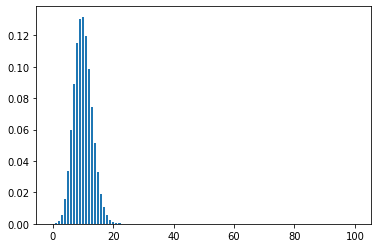

In [33]:
n = 100 # количество попыток
p = 0.1 # вероятность успеха

distr = []

for k in range(0, n + 1):
    current_value = binom.pmf(k, n, p)
    distr.append(current_value)
    
plt.bar(range(0, n + 1), distr)

/opt/conda/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


<BarContainer object of 851 artists>

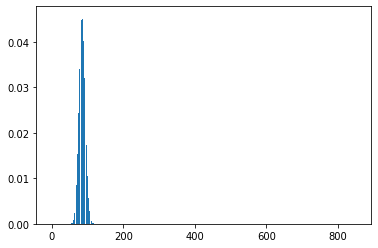

In [34]:
n = 850 # кол-во поп
p = 0.1 

distr = []

for k in range(0, n + 1):
    current_value = binom.pmf(k, n, p)
    distr.append(current_value)
    
plt.bar(range(0, n + 1), distr)

по рассчетам,можно сказать,что для достижения цели необходимо разослать минимум 850 промокодов при условии того что,огда высылают 100 промокодов результат приносят только 10%

7.2 Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40% получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

In [35]:
n = 1000000# задайте параметры 
p = 0.4# биномиального распределения

mu = n*p# рассчитайте параметры 
sigma = sqrt(n*p*(1-p))# нормального распределения

distr = st.norm(mu,sigma)# задайте нормальное распределение

result = distr.cdf(399500)# найдите вероятность
print(result)

0.15371708296369768


Шанс того,что уведомления откроют не более 399,5 тысяч пользователе составляет 15%

<div class="alert alert-success">

**Артём:** 👍 Все правильно - 15%. 
  
</div> 

#### Вывод

Для изучение датафреймов были импортированы 7 библиотек

В ходе иследования были обнаружены был выявлен неверный формат данных в стобце date.А так же просмотрена общая информация о них и составлено описание столбцов.Данные были успешно переформатирвоаны,были выявлены дубликаты в количестве 31 штук -так же успешно удалены,пропусков не выявлено

Так же были установлены самые популярные города это Пятигорск и ЕКБ,выявлено что количество пользователей без подписки преобладает над пользователями с ней лишь на 10 процентов.

Был составлен портрет среднего пользователя,от молодые люди приблизительно 25 лет,проезжают от 2-4.5км ,и тратят на поездку от 15 жо 20 минут

Для более детальног оанализа 3 баззы данных были объеденены в 1 и разбиты по группам

Пользователи с подпиской в среднем проезжают отот 6 до 12 км и тратят на поездку до 20 минут,В то время как пользователи без подписки проезжаютт расстояние в 3 раза меньше.Это говорит о том,что скорее всего они берут самокаты в целях развлечения,могут просто покататься с друзьями,оставиться поесть мороженого и поболтать

Из данного датафрема был составлен еще 1 но данным в нем были агрегирующие это позовлило найти суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.А так же благодаря ему были произведены расчеты помесячной выручкой, которую принёс каждый пользователь и добавлены в дадатфрейм

Были првоерены 3 гипотезы которые гласят:

1-Время продолжительности поездок на free и ultra неравны,различаются

2-Не получилось отвергунть,что расстоение которые проезжают пользователи равно 3130м

3-H1 не отвергаем,что выручка на free и ultra отличаются